In [1]:
# ===============================
# Librairies
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import Add, Dense, Dropout, Embedding, Input, Layer, LayerNormalization, Multiply, Permute, Reshape
from keras.models import Model

import pickle
import yfinance as yf
from sklearn.linear_model import LinearRegression


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/Users/tomcuel/.venvs/global_env/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Building the encoder-decoder transformer for multi-asset time series forecasting

In [2]:
class Decoder:
    def __init__(self,
        num_layers,
        d_model,
        num_heads,
        d_ff,
        dropout_rate,
        ffn_activation=tf.keras.activations.relu,
        scope="decoder"
    ):
        self.d_model = d_model
        self.num_layers = num_layers
        self.scope = scope

        self.pos_encoding = PositionalEncoding(d_model, name="%s_positional_encoding" % scope)

        self.dec_layers = [
            DecoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         d_ff=d_ff,
                         dropout_rate=dropout_rate,
                         ffn_activation=ffn_activation,
                         scope="%s_decoder_layer_%d" % (scope, i))
            for i in range(num_layers)
        ]

        self.dropout = Dropout(dropout_rate, name="%s_dropout" % self.scope)

    def __call__(self, x, enc_output, lookahead_mask, padding_mask):
        x = MultiplyConstant(tf.cast(self.d_model, tf.float32), name="%s_multiply" % self.scope)(x)
        x = Add(name="%s_add" % self.scope)([x, self.pos_encoding(x)])

        dec_attention_weights = {}
        enc_dec_attention_weights = {}

        for i in range(self.num_layers):
            x, dec_attention, enc_dec_attention = self.dec_layers[i](
                x, enc_output, lookahead_mask, padding_mask)

            dec_attention_weights["layer_%d" % i] = dec_attention
            enc_dec_attention_weights["layer_%d" % i] = enc_dec_attention

        return x, dec_attention_weights, enc_dec_attention_weights


class Encoder:
    def __init__(self,
        num_layers,
        d_model,
        num_heads,
        d_ff,
        dropout_rate,
        ffn_activation=tf.keras.activations.relu,
        scope="encoder"
    ):
        self.d_model = d_model
        self.num_layers = num_layers
        self.scope = scope

        self.pos_encoding = PositionalEncoding(d_model, name="%s_positional_encoding" % scope)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         d_ff=d_ff,
                         dropout_rate=dropout_rate,
                         ffn_activation=ffn_activation,
                         scope="%s_encoder_layer_%d" % (scope, i))
            for i in range(num_layers)
        ]

        self.dropout = Dropout(dropout_rate, name="%s_dropout" % self.scope)

    def __call__(self, x, padding_mask):
        x = MultiplyConstant(tf.cast(self.d_model, tf.float32), name="%s_multiply" % self.scope)(x)
        x = Add(name="%s_add" % self.scope)([x, self.pos_encoding(x)])

        enc_attention_weights = {}

        for i in range(self.num_layers):
            x, enc_attention = self.enc_layers[i](x, padding_mask)
            enc_attention_weights["layer_%d" % i] = enc_attention

        return x, enc_attention_weights


class DecoderLayer:
    def __init__(self,
        d_model,
        num_heads,
        d_ff,
        dropout_rate,
        ffn_activation=tf.keras.activations.relu,
        scope="decoder_layer"
    ):
        self.scope = scope

        self.mha1 = MultiHeadAttention(d_model, num_heads, scope="%s_multi_head_attention_1" % scope)
        self.mha2 = MultiHeadAttention(d_model, num_heads, scope="%s_multi_head_attention_2" % scope)
        self.ffn = PointwiseFeedForwardNetwork(d_model, d_ff, activation=ffn_activation, scope="%s_pointwise_feed_forward_network" % scope)

        self.layernorm1 = LayerNormalization(epsilon=1e-6, name="%s_layer_norm_1" % scope)
        self.layernorm2 = LayerNormalization(epsilon=1e-6, name="%s_layer_norm_2" % scope)
        self.layernorm3 = LayerNormalization(epsilon=1e-6, name="%s_layer_norm_3" % scope)

        self.dropout1 = Dropout(dropout_rate, name="%s_dropout_1" % scope)
        self.dropout2 = Dropout(dropout_rate, name="%s_dropout_2" % scope)
        self.dropout3 = Dropout(dropout_rate, name="%s_dropout_3" % scope)

    def __call__(self, x, enc_output, lookahead_mask, padding_mask):
        out1, dec_dec_attention = self.mha1(x, x, x, lookahead_mask)
        out1 = self.dropout1(out1)
        x = Add(name="%s_add_1" % self.scope)([x, out1])
        x = self.layernorm1(x)

        out2, enc_dec_attention = self.mha2(x, enc_output, enc_output, padding_mask)
        out2 = self.dropout2(out2)
        x = Add(name="%s_add_2" % self.scope)([x, out2])
        x = self.layernorm2(x)

        ffn_output = self.ffn(x)
        ffn_output = self.dropout3(ffn_output)
        x = Add(name="%s_add_3" % self.scope)([x, ffn_output])
        x = self.layernorm3(x)

        return x, dec_dec_attention, enc_dec_attention


class EncoderLayer:
    def __init__(self,
        d_model,
        num_heads,
        d_ff,
        dropout_rate,
        ffn_activation=tf.keras.activations.relu,
        scope="encoder_layer"
    ):
        self.scope = scope
        self.mha1 = MultiHeadAttention(d_model, num_heads, scope="%s_multi_head_attention_1" % scope)
        self.ffn = PointwiseFeedForwardNetwork(d_model, d_ff, activation=ffn_activation, scope="%s_pointwise_feed_forward_network" % scope)

        self.layernorm1 = LayerNormalization(epsilon=1e-6, name="%s_layer_norm_1" % scope)
        self.layernorm2 = LayerNormalization(epsilon=1e-6, name="%s_layer_norm_2" % scope)

        self.dropout1 = Dropout(dropout_rate, name="%s_dropout_1" % scope)
        self.dropout2 = Dropout(dropout_rate, name="%s_dropout_2" % scope)

    def __call__(self, x, padding_mask):
        out1, enc_enc_attention = self.mha1(x, x, x, padding_mask)
        out1 = self.dropout1(out1)
        x = Add(name="%s_add_1" % self.scope)([x, out1])
        x = self.layernorm1(x)

        ffn_output = self.ffn(x)
        ffn_output = self.dropout2(ffn_output)
        x = Add(name="%s_add_2" % self.scope)([x, ffn_output])
        x = self.layernorm2(x)

        return x, enc_enc_attention


class PointwiseFeedForwardNetwork:
    def __init__(self,
        d_model,
        d_ff,
        activation=tf.keras.activations.relu,
        scope="pointwise_feed_forward_network"
    ):
        self.dense_1 = Dense(d_ff, activation=activation, name="%s_dense_1" % scope)
        self.dense_2 = Dense(d_model, activation=None, name="%s_dense_2" % scope)

    def __call__(self, x):
        return self.dense_2(self.dense_1(x))


class MultiHeadAttention:
    def __init__(self, d_model, num_heads, scope="multi_head_attention"):
        assert d_model % num_heads == 0

        self.wq = Dense(d_model, name="%s_dense_q" % scope)
        self.wk = Dense(d_model, name="%s_dense_k" % scope)
        self.wv = Dense(d_model, name="%s_dense_v" % scope)

        self.reshapeq = Reshape((-1, num_heads, d_model // num_heads), name="%s_reshape_q" % scope)
        self.reshapek = Reshape((-1, num_heads, d_model // num_heads), name="%s_reshape_k" % scope)
        self.reshapev = Reshape((-1, num_heads, d_model // num_heads), name="%s_reshape_v" % scope)

        self.transposeq = Permute((2, 1, 3), name="%s_transpose_q" % scope)
        self.transposek = Permute((2, 1, 3), name="%s_transpose_k" % scope)
        self.transposev = Permute((2, 1, 3), name="%s_transpose_v" % scope)

        self.reshape_output = Reshape((-1, d_model), name="%s_reshape_output" % scope)

        self.transpose_output = Permute((2, 1, 3), name="%s_transpose_output" % scope)

        self.dense = Dense(d_model, name="%s_dense" % scope)

        self.attention = Attention(name="%s_attention" % scope)

    def __call__(self, q, k, v, mask):
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.reshapeq(q)
        k = self.reshapek(k)
        v = self.reshapev(v)

        q = self.transposeq(q)
        k = self.transposek(k)
        v = self.transposev(v)

        x, attention_weights = self.attention([q, k, v, mask])

        x = self.transpose_output(x)
        x = self.reshape_output(x)
        x = self.dense(x)

        return x, attention_weights


class Attention(Layer):
    def call(self, inputs):
        q, k, v, mask = inputs

        matmul_qk = tf.matmul(q, k, transpose_b=True)

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        scaled_attention_logits += mask * -1e9

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights


class PositionalEncoding(Layer):
    def __init__(self, d_model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.d_model = d_model

    def call(self, inputs):
        position = tf.shape(inputs)[1]

        position_dims = tf.range(position)[:, tf.newaxis]
        embed_dims = tf.range(self.d_model)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000.0, tf.cast((2 * (embed_dims // 2)) / self.d_model, tf.float32))
        angle_rads = tf.cast(position_dims, tf.float32) * angle_rates

        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def get_config(self):
        base = super().get_config()
        return dict(list(base.items()) + [("d_model", self.d_model)])


class MultiplyConstant(Layer):
    def __init__(self, c, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.c = c

    def call(self, inputs):
        return inputs * self.c

    def get_config(self):
        base = super().get_config()
        return dict(list(base.items()) + [("c", self.c)])


class PaddingMask(Layer):
    def call(self, inputs):
        n_batch = tf.shape(inputs)[0] # batch size (None)
        n_tsteps = tf.shape(inputs)[1] # time steps
        seq = tf.zeros([n_batch, n_tsteps])
        return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size=None, 1, 1, time_steps)

class PaddingAndLookaheadMask(Layer):
    def call(self, inputs):
        n_batch = tf.shape(inputs)[0] # batch size (None)
        n_tsteps = tf.shape(inputs)[1] # time steps
        lhm = 1 - tf.linalg.band_part(tf.ones((n_tsteps, n_tsteps)), -1, 0)
        lhm = lhm[tf.newaxis, tf.newaxis, :, :]  # (1, 1, time_steps, time_steps)
        lhm = tf.repeat(lhm, repeats=n_batch, axis=0)  # (batch_size=None, 1, time_steps, time_steps)
        return lhm

In [3]:
start = "2000-01-01"
end = '2024-10-19'
sp500 = yf.download('^GSPC', start, end) # S&P500
dow = yf.download('^DJI', start, end)  # DOW
nasdaq = yf.download('^IXIC', start, end) # NASDAQ

price = pd. DataFrame ()
price['SP500'] = sp500['Close']
price['DOW'] = dow['Close']
price['NASDAQ'] = nasdaq['Close']
price = price.dropna ()
price.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SP500,DOW,NASDAQ
Date,,,
2000-01-03,1455.219971,11357.509766,4131.149902
2000-01-04,1399.420044,10997.929688,3901.689941
2000-01-05,1402.109985,11122.650391,3877.540039
2000-01-06,1403.449951,11253.259766,3727.129883
2000-01-07,1441.469971,11522.559570,3882.620117


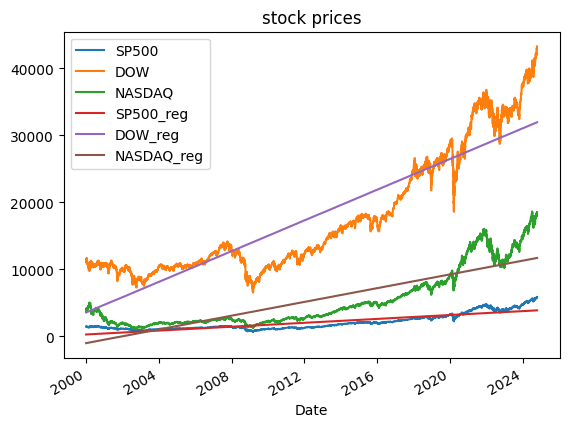

In [4]:
def regression (x, y) :
    model = LinearRegression()
    model. fit (x, y)
    return model.predict (x)

# Finding regression line, trend of stock price
x = np.arange(price.shape[0], dtype='float').reshape(-1, 1)
price['SP500_reg'] = regression(x, price['SP500'])
price['DOW_reg'] = regression (x, price['DOW'])
price['NASDAQ_reg'] = regression (x, price['NASDAQ'])
price.plot()
plt.title("stock prices")
plt.show()

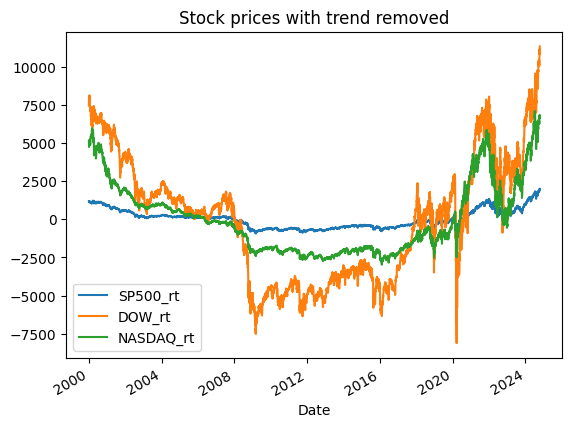

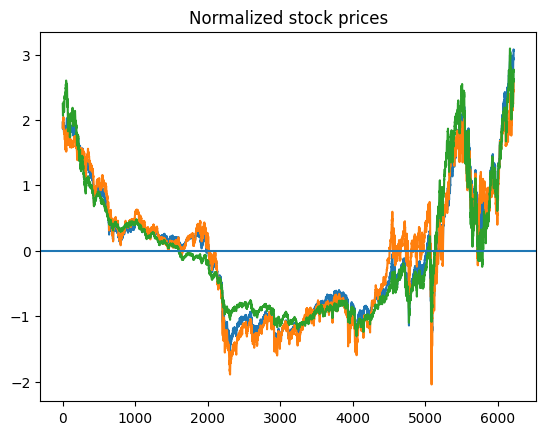

In [5]:
# Removing trend from stock price
price['SP500_rt'] = price['SP500'] - price['SP500_reg']
price['DOW_rt'] = price['DOW'] - price['DOW_reg']
price['NASDAQ_rt'] = price['NASDAQ'] - price['NASDAQ_reg']
price_rt = price[['SP500_rt', 'DOW_rt', 'NASDAQ_rt']]
price_rt.plot()
plt.title("Stock prices with trend removed") 
plt.show()

# Normalize stock prices
price_rt = np.array(price_rt)
mean = np.mean(price_rt, axis=0)
std = np.std(price_rt, axis=0)
price_rt = (price_rt - mean) / std

# Split the price data into training data and test data
x_train = price_rt[:-20] # training data
x_test = price_rt[-20:] # test data

# Generate training dataset for a transformer model
t = 60 # the number of sequences
n = x_train.shape[0] # the number of training data points
m = np.arange(0, n-2*t+1) 
xi_enc=np.array([x_train[i:(i+t), :] for i in m]) # encoder input
xi_dec=np.array([x_train[(i+t-1):(i+2*t-1), :] for i in m]) # decoder input
xo_dec=np.array([x_train[(i+t):(i+2*t), :] for i in m]) # decoder output

# Save the training and test data for later use
with open('stock_data.pkl', 'wb') as f:
    pickle.dump([x_train, x_test, xi_enc, xi_dec, xo_dec], f)

plt.plot(x_train)
plt.title("Normalized stock prices")
plt.axhline (0)
plt.show()

In [6]:
# Read dataset
with open ('stock_data.pkl', 'rb') as f:
    x_train, x_test, xi_enc, xi_dec, xp_dec = pickle.load(f)

n_tstep = xi_enc.shape[1] # 60
n_feat = xi_enc. shape[2] # 3
d_model = 120

# Encoder
EmbDense = Dense(d_model, use_bias=False)
i_enc = Input(batch_shape=(None, n_tstep, n_feat))
h_enc = EmbDense(i_enc)
padding_mask = PaddingMask()(h_enc)
encoder = Encoder(num_layers = 2,
                d_model = d_model,
                num_heads = 4,
                d_ff = 128,
                dropout_rate=0.5
            )
o_enc, _ = encoder(h_enc, padding_mask)

# Decoder
i_dec = Input(batch_shape=(None, n_tstep, n_feat))
h_dec = EmbDense(i_dec)
lookahead_mask = PaddingAndLookaheadMask()(h_dec)
decoder = Decoder(num_layers = 2,
                d_model = d_model,
                num_heads = 4,
                d_ff = 128,
                dropout_rate=0.5
            )
o_dec, _, _ = decoder(h_dec, o_enc, lookahead_mask, padding_mask)

# Final Dense layer
y_dec = Dense(n_feat)(o_dec)

# Define the model
model = Model(inputs=[i_enc, i_dec], outputs=y_dec)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 60, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60, 120)   │        360 │ input_layer[0][0… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_multiply    │ (None, 60, 120)   │          0 │ dense[0][0]       │
│ (MultiplyConstant)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_positional… │ (1, 60, 120)      │          0 │ encoder_multiply… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_add (Add)   │ (1, 60, 120)      │          0 │ encoder_multiply… │
│                     │                   │            │ encoder_position… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ (1, 60, 120)      │     14,520 │ encoder_add[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ (1, 60, 120)      │     14,520 │ encoder_add[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ (1, 60, 120)      │     14,520 │ encoder_add[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ (1, 60, 4, 30)    │          0 │ encoder_encoder_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ (1, 60, 4, 30)    │          0 │ encoder_encoder_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ (1, 60, 4, 30)    │          0 │ encoder_encoder_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ (1, 4, 60, 30)    │          0 │ encoder_encoder_… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ (1, 4, 60, 30)    │          0 │ encoder_encoder_… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ (1, 4, 60, 30)    │          0 │ encoder_encoder_… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, 1, 1, 60)  │          0 │ dense[0][0]       │
│ (PaddingMask)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_encoder_la… │ [(None, 4, 60,    │          0 │ encoder_encoder_

 Total params: 475,475 (1.81 MB)

 Trainable params: 475,475 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - loss: 1.2918
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - loss: 0.5869
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - loss: 0.3956
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 0.2420
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - loss: 0.1647
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - loss: 0.1295
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - loss: 0.1145
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - loss: 0.1024
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - loss: 0.0898
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - loss: 0.0854
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - loss: 0.0916
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - loss: 0.0791
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - loss: 0.0778
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - loss: 0.0694
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - l

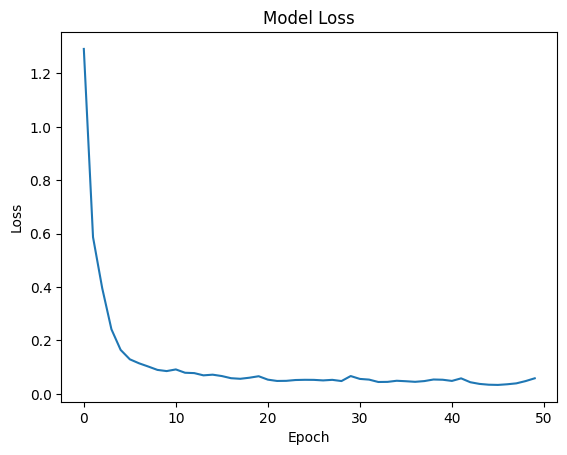

In [7]:
# Training : teacher forcing
history = model.fit(
    [xi_enc, xi_dec], xp_dec,
    epochs=50, batch_size=200
)

# see the loss curve
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [8]:
# Save the model 
model.save_weights('transformer_multi_asset.weights.h5')

In [22]:
# Trained encoder 
EmbDense = Dense(d_model, use_bias=False)
i_enc = Input(batch_shape=(None, n_tstep, n_feat))
h_enc = EmbDense(i_enc)
padding_mask = PaddingMask()(h_enc)
encoder = Encoder(num_layers = 2,
                d_model = d_model,
                num_heads = 4,
                d_ff = 128,
                dropout_rate=0.5
            )
o_enc, _ = encoder(h_enc, padding_mask)

# Trained decoder
i_dec = Input(batch_shape=(None, None, n_feat))
h_dec = EmbDense(i_dec)
lookahead_mask = PaddingAndLookaheadMask()(h_dec)
decoder = Decoder(num_layers = 2,
                d_model = d_model,
                num_heads = 4,
                d_ff = 128,
                dropout_rate=0.5
            )
o_dec, _, _ = decoder(h_dec, o_enc, lookahead_mask, padding_mask)

# Final Dense layer
y_dec = Dense(n_feat)(o_dec)

# Define the model
trained_model = Model(inputs=[i_enc, i_dec], outputs=y_dec)

# Load the trained weights
trained_model.load_weights('transformer_multi_asset.weights.h5')

In [31]:
# Prediction
n_past = 50
n_future = 20
e_data = x_train[-n_tstep:].reshape(1, n_tstep, n_feat)
d_data = np.zeros(shape=(1, n_future, n_feat))
d_data[0, 0, :] = x_train[-1]

for i in range(n_future):
    y_hat = trained_model.predict([e_data, d_data])
    if i < n_future - 1:
        d_data[0, i + 1, :] = y_hat[0, i, :]
    print(f"Predicted step {i+1}/{n_future} : {y_hat[0, i, :]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted step 1/20 : [2.4171667 2.0899746 2.2667449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted step 2/20 : [2.417234  2.0808501 2.2723117]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted step 3/20 : [2.420651 2.080018 2.278332]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted step 4/20 : [2.422664  2.0798266 2.2818654]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted step 5/20 : [2.4235656 2.0797145 2.2833784]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted step 6/20 : [2.4237354 2.0796485 2.283435 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted step 7/20 : [2.4237146 2.0796645 2.2829487]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted step 8/20 : [2.423913  2.0797198 2.2827353]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted step 9/20 : [2.4243288 2.0796702 2.283009 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted step 10/20 : [2.4246342 2.0793853 2.2833872]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted step 11/20 : [2.4245741 2.078896  

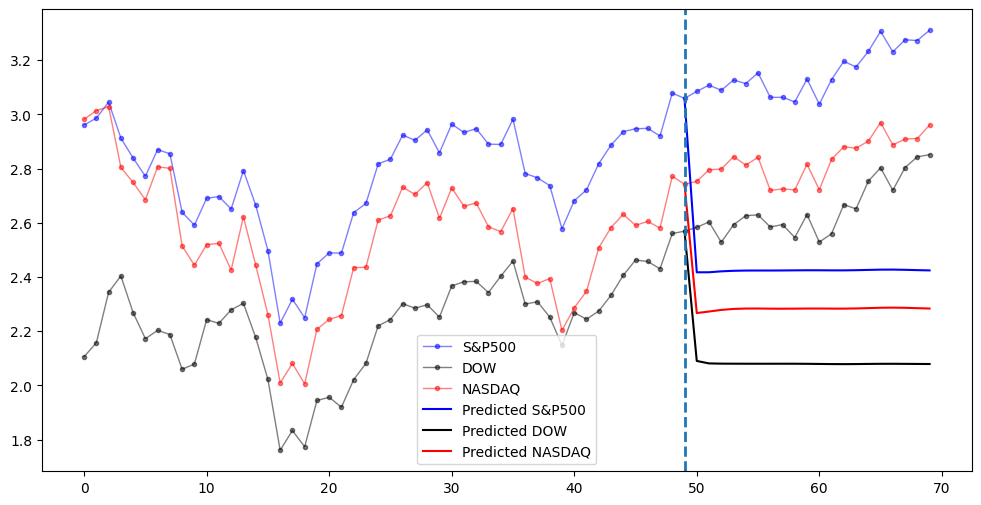

In [32]:
# Plot the past time series and the predicted future time series
y_hat_plot = np.vstack([x_train[-1], y_hat[0, :n_future, :]])
y_past = np.vstack([x_train[-n_past:], x_test])
plt.figure(figsize= (12, 6))
ax1 = np.arange(1, len(y_past) + 1)
ax2 = np. arange(n_past-1, n_past + n_future)
plt.plot(y_past[:, 0], '-o', c='blue', markersize=3, alpha=0.5, label='S&P500', linewidth=1)
plt.plot(y_past[:, 1], '-o', c='black', markersize=3, alpha=0.5, label='DOW', linewidth=1)
plt.plot(y_past[:, 2], '-o', c='red', markersize=3, alpha=0.5, label='NASDAQ', linewidth=1)
plt.plot(ax2, y_hat_plot[:, 0], c='blue', label='Predicted S&P500')
plt.plot(ax2, y_hat_plot[:, 1], c='black', label='Predicted DOW') 
plt.plot(ax2, y_hat_plot[:, 2], c='red', label='Predicted NASDAQ')
plt.axvline(x=n_past-1, linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

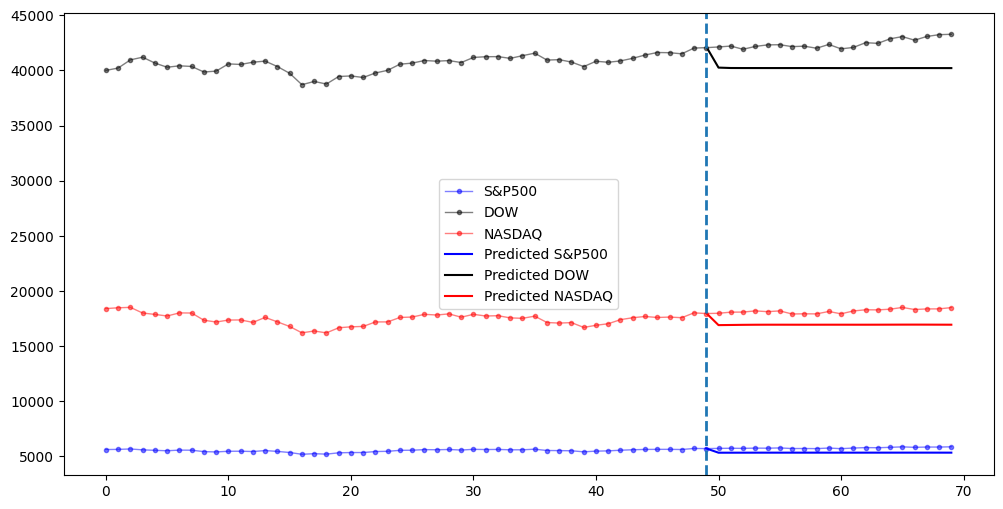

In [ ]:
# x_train and x_test are normalized & detrended, need to denormalize and add trend
price_trend = price[['SP500_reg', 'DOW_reg', 'NASDAQ_reg']].values

# Past history used in plot
y_past_real = np.vstack([x_train[-n_past:], x_test])  # normalized & detrended
trend_past = price_trend[-n_past - n_future:]           # corresponding trend
y_past_real = y_past_real * std + mean + trend_past   # real prices

# Reconstruct predicted series
y_hat_plot = np.vstack([x_train[-1], y_hat[0, :n_future, :]])  # keep normalized & detrended
trend_future = np.tile(price_trend[-1], (n_future + 1, 1)) # use last trend value to extend predictions
y_hat_real = y_hat_plot * std + mean + trend_future

# Plot the past time series and the predicted future time series
plt.figure(figsize= (12, 6))
ax1 = np.arange(1, len(y_past_real) + 1)
ax2 = np. arange(n_past-1, n_past + n_future)
plt.plot(y_past_real[:, 0], '-o', c='blue', markersize=3, alpha=0.5, label='S&P500', linewidth=1)
plt.plot(y_past_real[:, 1], '-o', c='black', markersize=3, alpha=0.5, label='DOW', linewidth=1)
plt.plot(y_past_real[:, 2], '-o', c='red', markersize=3, alpha=0.5, label='NASDAQ', linewidth=1)    
plt.plot(ax2, y_hat_real[:, 0], c='blue', label='Predicted S&P500')
plt.plot(ax2, y_hat_real[:, 1], c='black', label='Predicted DOW') 
plt.plot(ax2, y_hat_real[:, 2], c='red', label='Predicted NASDAQ')
plt.axvline(x=n_past-1, linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

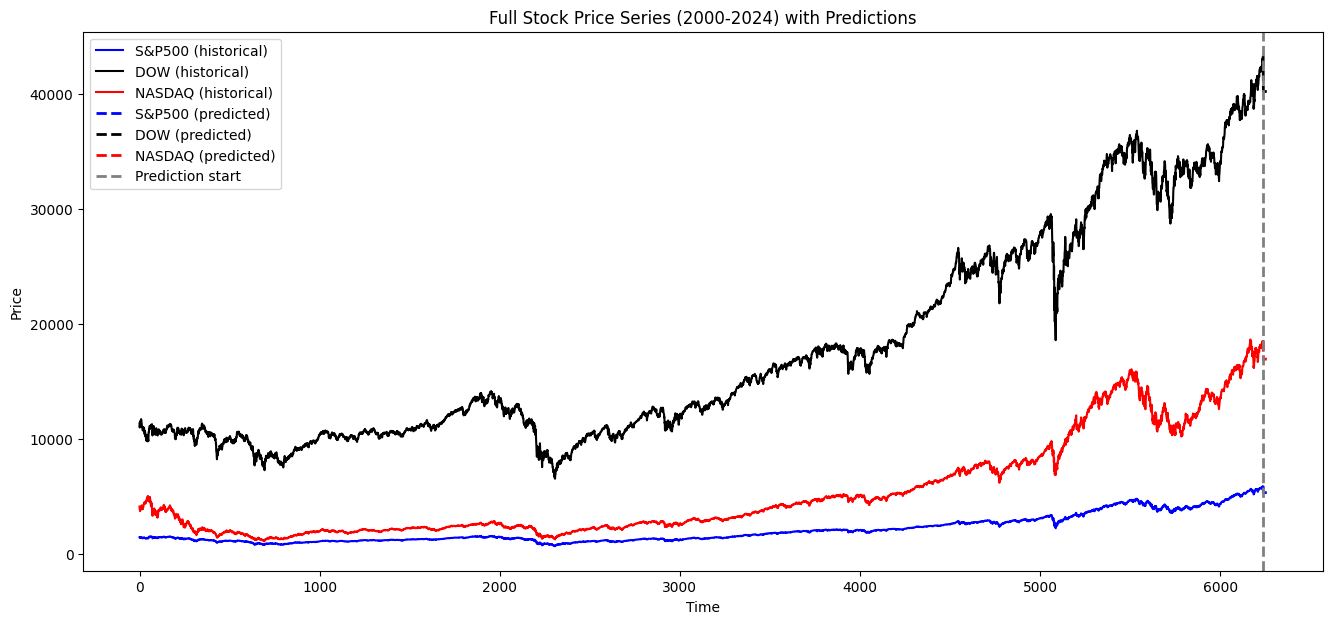

In [36]:
# De-normalize and add trend to the entire historical series
price_trend = price[['SP500_reg', 'DOW_reg', 'NASDAQ_reg']].values    # trend lines
price_norm = np.vstack([x_train, x_test])                             # normalized & detrended

# Full historical real prices
full_history = price_norm * std + mean + price_trend                  # real prices

# Predicted future series (n_future steps)
y_hat_plot = np.vstack([x_train[-1], y_hat[0, :n_future, :]])        # normalized & detrended
trend_future = np.tile(price_trend[-1], (n_future + 1, 1))           # extend last trend
y_hat_real = y_hat_plot * std + mean + trend_future                  # real prices

# Combine history + predictions for plotting
full_series = np.vstack([full_history, y_hat_real[1:]])  # exclude duplicated last point

# X-axis
ax_full = np.arange(full_series.shape[0])
prediction_start = len(full_history) - 1

# Plot
plt.figure(figsize=(16, 7))

# Historical series
plt.plot(ax_full[:len(full_history)], full_history[:,0], c='blue', label='S&P500 (historical)')
plt.plot(ax_full[:len(full_history)], full_history[:,1], c='black', label='DOW (historical)')
plt.plot(ax_full[:len(full_history)], full_history[:,2], c='red', label='NASDAQ (historical)')
# Predicted future
plt.plot(ax_full[prediction_start:], full_series[prediction_start:,0], '--', c='blue', label='S&P500 (predicted)', linewidth=2)
plt.plot(ax_full[prediction_start:], full_series[prediction_start:,1], '--', c='black', label='DOW (predicted)', linewidth=2)
plt.plot(ax_full[prediction_start:], full_series[prediction_start:,2], '--', c='red', label='NASDAQ (predicted)', linewidth=2)
# Vertical line marking start of prediction
plt.axvline(x=prediction_start, linestyle='dashed', color='gray', linewidth=2, label='Prediction start')
plt.title("Full Stock Price Series (2000-2024) with Predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()